(nonlinearity:exercise)=
### Von-May function

**Task 1**: Write a function which solves the Von-May-Equation.


**Problem description:**

<blockquote>The starting point for our analysis is the ‘Von-May-Equation’, which is given by <br>

    
**\begin{align}    
y_{t+1} = r \cdot y_{t} \cdot (1-y_{t}),
\end{align}**

with  $r$ an pre-defined parameter and $y$ the function value at time $t$ and $t+1$.</blockquote>

In [1]:
import matplotlib.pyplot as plt

def von_may(y0,r):
    # Write your code here
    pass



**Task 2:** Run the code for several initial and parameter combination. What is particularly striking about increasing r-values?


```
y(0)=0.5 and r=2.80 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.30 (alternatively, use y(0)=0.9) 
y(0)=0.5 and r=3.95 (alternatively, use y(0)=0.495) 
y(0)=0.8 and r=2.80 

```

In [2]:
# Integrate the equation and plot the results


**Extend the Von-May function**

**Task 3:** Extend this Von-May function by generating 20 random r-values and run simulations with them. Sample the values from a normal distribution with mean 3.95 and standard deviation 0.015 (limit the r-values between 0 and 4). Then average over all time series. Plot both the time series, the averaged time series and the histogram of the averaged time series. What do you observe?

In [3]:
import random
import numpy as np

def ensemble_may(n, y0, r):
    # Write your code here
    pass


In [4]:
# Plot the results

**Revisit the EBM-Model**

Include a dynamic transmissivity in the energy balance model.

**Task 4:** Run the energy balance model $T(0)=288 ~ K$, $C_w= 2\cdot10^8 ~ J/(m^2
 57 \cdot K)$, $\alpha=0.3$, and $\tau_{mean}=0.608 (\pm 10\%)$

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Import some modules which are used in the function
import random         # Module to generate random number
import numpy as np    # Numpy

def OLR(T, tau):
    """ Stefan-Boltzmann law """
    sigma = 5.67e-8              # Stefan-Boltzmann constant
    return tau * sigma * T**4    # Return the OLR calculated by the Stefan-Boltzmann law

def ASR(Q, alpha):
    """ Absorbed shortwave radiation """
    return (1-alpha) * Q         # Return the ASR, with the albedo value alpha


def step_forward(Q, T, Cw, alpha, tau, dt):
    # Return the updated T-value (time-dependent EBM)    
    return T + dt / Cw * ( ASR(Q, alpha) - OLR(T, tau) ) 



In [6]:
# Plot the results


**Extend the model with a simple ice/land use albedo parameterisation. (sigmoid version)**

**Task 5:** In this parameterisation, the albedo is solely a function of mean temperature. As a non-linear function we assume a sigmoid function with

\begin{align}
\alpha(T_i) = 0.3 \cdot (1-0.2 \cdot \tanh(0.5 \cdot (T_i-288))).
\end{align}

Run the energy balance model for 100 years with four different initial conditions for T(0)=286.0, 287.9, 288.0, and 293.0 K, while fixing the other parameters to $C_w$= 2$\cdot10^8$ J/(m$^2 \cdot$ K) and $\tau_{mean}$=0.608. 

What can be said about the state of equilibrium?

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    # Write your code here
    pass

In [8]:
# Plot the albedo function


In [9]:
# Run the simulations and plot the results


**Extend the model with a simple ice/land use albedo parameterisation. (linear version)**

**Task 6:** In this parameterisation, the albedo is solely a function of mean temperature. We assume a simple linear relation according to

\begin{align}
    f(x)= 
\begin{cases}
    \alpha_i,& \text{if } T\leq T_i\\
    \alpha_g,& \text{if } T \geq T_g\\
    \alpha_g+b(T_g-T) & \text{if } T_i<T<T_g
\end{cases}
\end{align}

with $T_i$=273 K, and $T_g$= 292 K. Run the energy balance model for 100 years with four different initial conditions for T(0)=286.0, 287.9, 288.0, and 293.0 K, while fixing the other parameters to $C_w$= 2$\cdot10^8$ J/(m$^2 \cdot$ K), and $\tau_{mean}$=0.608, $a_i$=0.6, and $a_g$=0.2. 

What can be said about the state of equilibrium?

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo_2(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.608, years=100):
    # Write your code here
    pass

In [11]:
# Run the simulations and plot the results


**Task 7:** Determine the equilibrium climate sensitivity (ECS) and the feedback factor for the simulation from Task 5 using T(0)=289 K.  (sigmoid albedo parametrisation)

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt


def ebm_ice_albedo_stochastic_ECS(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model with a random transmissivity and 
    ice-albedo feedback.'''
      
    # Timestep in seconds (time step is 1 year)
    dt = 60*60*24*365                  # convert days to seconds
    
    # Create result arrays (numpy) filled with zeros
    # Ts stores the temperature values, Years the years since the beginning of
    # the simulation, netQ the net radiation flux, and dT the temperature change
    Ts    = np.zeros(years+1) # Temperature 
    netQ  = np.zeros(years)   # Net radiation flux at the tropopause
    dT    = np.zeros(years)   # Temperature change
    Years = np.zeros(years+1) # Years since simulation start
    
    # Initial and boundary conditions
    Ts[0] = T0

    # Integrate over all years
    for n in range(years):
        # Calculate the albedo value
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))
        alpha_adapt =0.3
        # Generate a random transmissivity
        tau_rnd = random.normalvariate(tau,tau*0.01)
        # Store the interation (year)
        Years[n+1] = n+1
        # Calculate the new tempeature
        Ts[n+1] = step_forward(Q, Ts[n], Cw, alpha_adapt, tau, dt)
        
        # Store the net radiation flux at the tropopause ASR-OLR
        netQ[n] = ASR(Q, alpha_adapt) - OLR(Ts[n], tau)
        
        # Store the temperature change between the current and previous step
        dT[n] = Ts[n] - Ts[0]
        
    # Return all result arrays
    return Years, Ts, dT, netQ

The ECS is -0.32 ºC
The feedback factor is -3.08, which implies a negative feedback


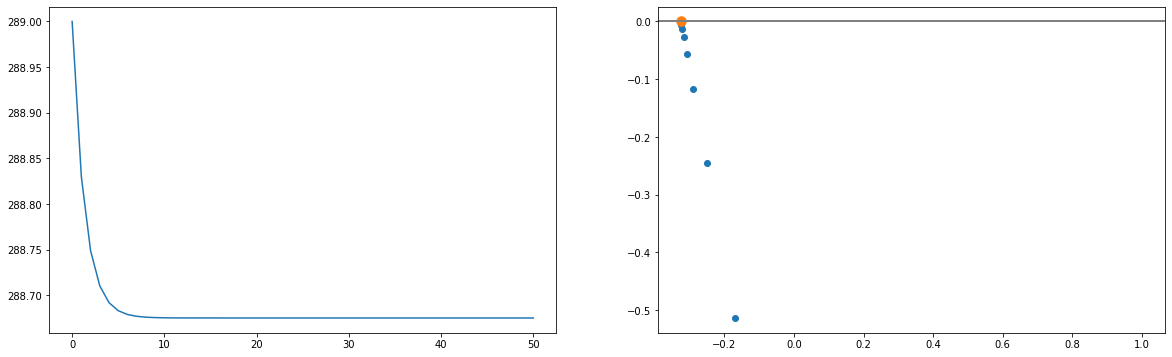

In [13]:
# Run the simulations and plot the results
yrs, Ts, dT, netQ = ebm_ice_albedo_stochastic_ECS(289, Q=342, Cw=2*10**8, \
                                                     alpha=0.30, tau=0.608, years=50)
# Create subplots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))

# Temperature time series
ax1.plot(yrs, Ts)

# Create a scatter plot: temperature change vs. net radiation flux
ax2.scatter(dT[1:], netQ[1:])

# Fit a regression line to the scatter plot
m, b = np.polyfit(dT[1:], netQ[1:],1)

# Add regression line to scatter plot
x = np.arange(0,np.max(dT),0.1)
ax2.plot(x, m*x+b)
ax2.axline((0,0),(1,0), linewidth=2, color='gray')
ax2.scatter(-b/m,0, s=90)


# Calculate the ECS from the regression line and print the result
print('The ECS is {:.2f} ºC'.format(-b/m))
print('The feedback factor is {:.2f}, which implies a negative feedback'.format(-m/b))

**Task 8:** Repeat the simulation from Task 5 (sigmoid function for albedo) with T(0)=289 K, but again sample the transmissivity from a normal distribution with a standard deviation of 10%.  

What special feature can now be observed? What conclusions can be inferred regarding the prediction of weather and climate?

In [14]:
# Import some modules which are used in the function
import random         # Module to generate random number
import numpy as np    # Numpy


def ebm_ice_albedo_stochastic(T0, Q=341.3, Cw=10e8, alpha=0.3, tau=0.64, years=100):
    ''' This is a simple Energy Balance Model including ice-albedo feedback.'''
  
    # Create result arrays (numpy) filled with zeros
    # Ts stores the temperature values, years the years since the beginning of
    # the simulation
    Ts    = np.zeros(years+1)
    Years = np.zeros(years+1)
    
    # Timestep in seconds (time step is 1 year)
    dt = 60*60*24*365                  # convert days to seconds

    # Initial and boundary conditions
    # Set the first value in the Ts to the initial condition
    Ts[0] = T0 

    # Integration over all years
    for n in range(years):
        # Parametrization of albedo. The albedo is a function of temperature.
        alpha_adapt = alpha * (1 - 0.2 * np.tanh(0.5*(Ts[n]-288)))

        # Sample the transmissivity from a normal distribution with a standard deviation of 10%
        tau_rnd = random.normalvariate(tau, tau*0.1) 

        # Store the number of iterations in the Years array
        Years[n+1] = n+1
        # Store the new temperature value in Ts
        Ts[n+1] = step_forward( Q, Ts[n], Cw, alpha_adapt, tau_rnd, dt )
        
    # Return both the temperature and year array
    return Years, Ts



(array([ 30., 120., 242., 287., 166.,  97.,  38.,  11.,   7.,   3.]),
 array([268.49496634, 271.68075319, 274.86654003, 278.05232688,
        281.23811372, 284.42390057, 287.60968742, 290.79547426,
        293.98126111, 297.16704795, 300.3528348 ]),
 <BarContainer object of 10 artists>)

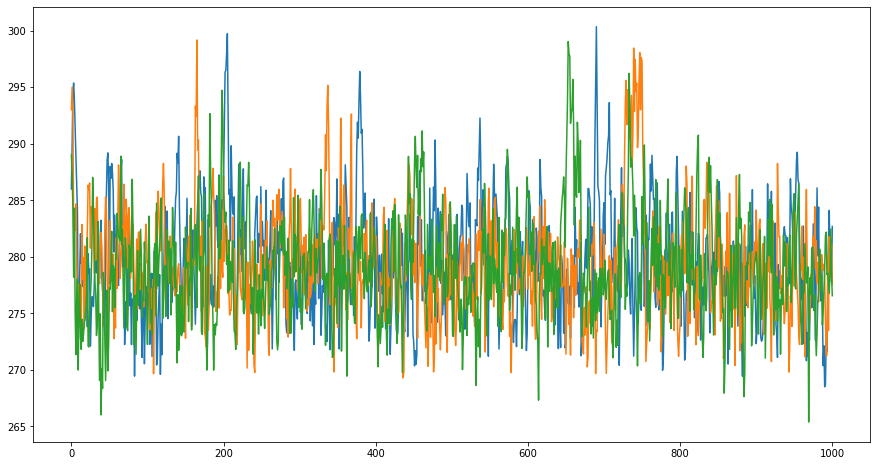

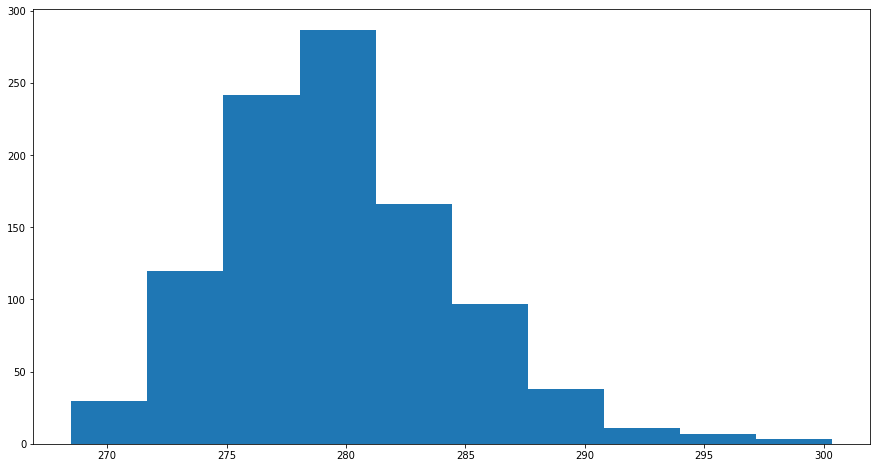

In [15]:
# Plot the results
yrs, Ts286 = ebm_ice_albedo_stochastic(286, Q=342, 
                                       Cw=2*10**8, years=1000)

yrs, Ts293 = ebm_ice_albedo_stochastic(293, Q=342, 
                                       Cw=2*10**8, years=1000)

yrs, Ts289 = ebm_ice_albedo_stochastic(289, Q=342, 
                                       Cw=2*10**8, years=1000)

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(yrs, Ts286)
ax.plot(yrs, Ts293)
ax.plot(yrs, Ts289)

fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.hist(Ts286)

In [16]:
# Make more plots to illustrate the characteristics of the time series